# PortfolioBuilder

### Purpose
This Jupyter Notebook is specifically designed to analyze the financial performance and health of selected companies with the goal of determining their potential value as additions to an investment portfolio. By examining key financial metrics and trends, this notebook aims to provide an in-depth understanding and a data-driven approach to aid in making informed investment decisions. The analysis will cover various financial aspects including profitability, liquidity, and growth potential, which are critical for assessing whether a company stands as a promising investment opportunity.


### How to Use This Notebook
To use this notebook effectively, you will need to set up a specific Python environment which includes all the necessary libraries and their dependencies. Follow these steps to prepare your environment:

#### Step 1: Clone the Repository
If applicable, clone the repository containing this notebook and associated files (like the environment file) to your local machine using:
```bash
git clone [URL-to-your-repository]
```

#### Step 2: Create the env
Use the following commands to create and activate the Conda environment from the YAML file included in the directory `conda`:
```bash
cd conda
conda env create -f notebooks_portfolio_builder.yml
```

#### Step 3: Activating the env
```bash
conda activate portfolio_builder
```

### Author
- Name: Mauro Andretta
- Date Created: 2024/07/25
- Contact: mauo.andretta222@gmail.com

In [1]:
# Import necessary libraries
import yfinance as yf
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter
import pandas as pd
import os
import time

# array operations
import numpy as np

# read config file
import configparser

# progress bar
import pyprind

# visualize
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Create a ConfigParser object
config = configparser.ConfigParser()

# Read the config.ini file
config.read('config.ini')

# Retrieve the paths from the config file
csv_folder = config.get('Paths', 'csv_folder')

# check if the csv and excel folder exists
# if not create them
try:
    if not os.path.exists(csv_folder):
        os.makedirs(csv_folder)
        print(f"Directory {csv_folder} created")
    else:
        print(f"Directory {csv_folder} already exists")
    
except Exception as e:
    print(f"An error occurred: {e}")

Directory companies_data/csv_files created


# Fetch stock data

In [10]:
def save_company_data_to_csv(ticker_symbol: str, company_data: dict, root_dir: str, period: str) -> None:
    """
    This function takes a stock ticker as input and saves the company data to a CSV file.
    Args:
        ticker_symbol (str): The stock ticker of the company for which the data is to be fetched.
        company_data (dict): A dictionary containing different types of financial data for the given stock ticker.
        root_dir (str): The root directory where the data will be saved.
        period (str): The period for which the data is to be fetched (e.g., '1d', '1mo', '1y', '5y', etc.).
    """

    # Create the root directory if it does not exist
    if not os.path.exists(root_dir):
        os.makedirs(root_dir)

    # Create a directory for the company if it does not exist
    company_dir = os.path.join(root_dir, period, ticker_symbol)
    if not os.path.exists(company_dir):
        os.makedirs(company_dir)

    # Iterate over the dictionary and save each item to a CSV file
    for key, value in company_data.items():
        if isinstance(value, pd.DataFrame):
            file_path = os.path.join(company_dir, f"{key}.csv")
            value.to_csv(file_path)
            #print(f"Saved {key}.csv in {company_dir}/")
    
    

In [11]:
def get_company_data(ticker_symbol: str, period: str = "1y") -> dict:
    """
    This function takes a stock ticker as input and returns a dictionary containing different types of financial data.

    Parameters:
    ticker (str): The stock ticker of the company for which the data is to be fetched.
    period (str): The period for which the data is to be fetched. It can be one of the following options: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max.

    Returns:
    dict: A dictionary containing different types of financial data for the given stock ticker.
    """
    # check if the period is valid
    if period not in ["1d", "5d", "1mo", "3mo", "6mo", "1y", "2y", "5y", "10y", "ytd", "max"]:
        raise ValueError("Invalid period. Please enter a valid period from the following options: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max")
    
    try:
        # get all stock info
        company = yf.Ticker(ticker_symbol)
        
        # get historical market data
        info = company.info

        # show meta information about the history 
        historical_data = company.history(period=period)
        actions = company.actions
        dividends = company.dividends
        splits = company.splits
        capital_gains = company.capital_gains

        # show financials:
        # - financials
        financials = company.financials
        quarterly_financials = company.quarterly_financials
        # - income statement
        income_stmt = company.income_stmt
        quarterly_income_stmt = company.quarterly_income_stmt
        # - balance sheet
        balance_sheet = company.balance_sheet
        quarterly_balance_sheet = company.quarterly_balance_sheet
        # - cash flow statement
        cashflow = company.cashflow
        quarterly_cashflow = company.quarterly_cashflow


        sustainability = company.sustainability
        recommendations = company.recommendations
        calendar = company.calendar
        news = company.news
        isin = company.isin

        # Store data in a dictionary
        data = {
            "info": info,

            "historical_data": historical_data,

            "actions": actions,
            "dividends": dividends,
            "splits": splits,
            "capital_gains": capital_gains,

            "financials": financials,
            "quarterly_financials": quarterly_financials,
            "income_stmt": income_stmt,
            "quarterly_income_stmt": quarterly_income_stmt,
            "balance_sheet": balance_sheet,
            "quarterly_balance_sheet": quarterly_balance_sheet,
            "cashflow": cashflow,
            "quarterly_cashflow": quarterly_cashflow,

            "sustainability": sustainability,
            "recommendations": recommendations,
            "calendar": calendar,
            "news": news,
            "isin": isin
        }

    except Exception as e:
        print(f"An error occurred: {e}")
        print(f"Could not fetch data for {ticker_symbol}")
        print("The data for this company will not be saved.")
        data = None
    
    return data

In [12]:
# add a try except block to catch any errors
ticker = ["TCEHY", "HSBC", "RTX", "ROG.SW", "SSNLF", "TM", "UL", "NVDA", "QBE.AX", 
          "RIO", "MHR.SG", "RMS.PA", "ESLOY", "SPOT", "WMT", "ENR.DE", "ABNB", "BAYN.DE", "MMM", "EL.PA", ]
range_analysis = "1y" # valid options are: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max


In [15]:
def fetch_ticker_data(ticker_symbols: list, period: str) -> None:
    """
    Fetches data for a list of stock tickers.
    Args:
        ticker_symbols (list): A list of stock tickers for which the data is to be fetched.
        period (str): The period for which the data is to be fetched (e.g., '1d', '1mo', '1y', '5y', etc.).
    """
    print(f"Fetching data for {ticker_symbols} companies!")

    try:
        # Iterate over the list of stock tickers and fetch the data for each company
        for ticker_symbol in ticker_symbols:
            print(f"Fetching data for {ticker_symbol}...")
            # Get the data for the company
            company_data = get_company_data(ticker_symbol, period)
            print(f"Data fetched for {ticker_symbol}")

            # Check if the company data is None
            if company_data is None:
                print(f"Could not fetch data for {ticker_symbol}")
                print("The data for this company will not be saved.")
                continue

            # Save the company data to a CSV file
            save_company_data_to_csv(ticker_symbol, company_data, csv_folder, period)
            print(f"Data saved for {ticker_symbol}")
    except Exception as e:
        print(f"An error occurred while extracting companies' financial info: {e}")
        # If there's a general error not caught by specific handlers, handle it here

In [16]:
# fetch the stocks data
fetch_ticker_data(ticker, range_analysis)

Fetching data for ['TCEHY', 'HSBC', 'RTX', 'ROG.SW', 'SSNLF', 'TM', 'UL', 'NVDA', 'QBE.AX', 'RIO', 'MHR.SG', 'RMS.PA', 'ESLOY', 'SPOT', 'WMT', 'ENR.DE', 'ABNB', 'BAYN.DE', 'MMM', 'EL.PA'] companies!
Fetching data for TCEHY...


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TCEHY?modules=esgScores&corsDomain=finance.yahoo.com&formatted=false&symbol=TCEHY&crumb=krbm%2FN9FDF8


Data fetched for TCEHY
Data saved for TCEHY
Fetching data for HSBC...


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HSBC?modules=esgScores&corsDomain=finance.yahoo.com&formatted=false&symbol=HSBC&crumb=krbm%2FN9FDF8


Data fetched for HSBC
Data saved for HSBC
Fetching data for RTX...


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RTX?modules=esgScores&corsDomain=finance.yahoo.com&formatted=false&symbol=RTX&crumb=krbm%2FN9FDF8


Data fetched for RTX
Data saved for RTX
Fetching data for ROG.SW...
Data fetched for ROG.SW
Data saved for ROG.SW
Fetching data for SSNLF...
Data fetched for SSNLF
Data saved for SSNLF
Fetching data for TM...


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/TM?modules=esgScores&corsDomain=finance.yahoo.com&formatted=false&symbol=TM&crumb=krbm%2FN9FDF8


Data fetched for TM
Data saved for TM
Fetching data for UL...


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/UL?modules=esgScores&corsDomain=finance.yahoo.com&formatted=false&symbol=UL&crumb=krbm%2FN9FDF8


Data fetched for UL
Data saved for UL
Fetching data for NVDA...
Data fetched for NVDA
Data saved for NVDA
Fetching data for QBE.AX...
Data fetched for QBE.AX
Data saved for QBE.AX
Fetching data for RIO...


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RIO?modules=esgScores&corsDomain=finance.yahoo.com&formatted=false&symbol=RIO&crumb=krbm%2FN9FDF8


Data fetched for RIO
Data saved for RIO
Fetching data for MHR.SG...


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MHR.SG?modules=esgScores&corsDomain=finance.yahoo.com&formatted=false&symbol=MHR.SG&crumb=krbm%2FN9FDF8
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MHR.SG?modules=recommendationTrend&corsDomain=finance.yahoo.com&formatted=false&symbol=MHR.SG&crumb=krbm%2FN9FDF8


Data fetched for MHR.SG
Data saved for MHR.SG
Fetching data for RMS.PA...
Data fetched for RMS.PA
Data saved for RMS.PA
Fetching data for ESLOY...


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ESLOY?modules=esgScores&corsDomain=finance.yahoo.com&formatted=false&symbol=ESLOY&crumb=krbm%2FN9FDF8


Data fetched for ESLOY
Data saved for ESLOY
Fetching data for SPOT...


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SPOT?modules=esgScores&corsDomain=finance.yahoo.com&formatted=false&symbol=SPOT&crumb=krbm%2FN9FDF8


Data fetched for SPOT
Data saved for SPOT
Fetching data for WMT...
Data fetched for WMT
Data saved for WMT
Fetching data for ENR.DE...


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ENR.DE?modules=esgScores&corsDomain=finance.yahoo.com&formatted=false&symbol=ENR.DE&crumb=krbm%2FN9FDF8


Data fetched for ENR.DE
Data saved for ENR.DE
Fetching data for ABNB...


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ABNB?modules=esgScores&corsDomain=finance.yahoo.com&formatted=false&symbol=ABNB&crumb=krbm%2FN9FDF8


Data fetched for ABNB
Data saved for ABNB
Fetching data for BAYN.DE...
Data fetched for BAYN.DE
Data saved for BAYN.DE
Fetching data for MMM...
Data fetched for MMM
Data saved for MMM
Fetching data for EL.PA...
Data fetched for EL.PA
Data saved for EL.PA


# Historichal data stocks analysis

In [18]:
# Loop over all the compaines in the companies/csv_files folder
# For each company, read the historical_data.csv as a DataFrame
# Create a new column in the DataFrame called "Returns" basedon the "Close" column
# Save the new created column to a new DataFrame with a column equal to the comapny name
# and values equal to the "Close Price Percentage Change" column
# Once all the company have been analysed, create the covariance and correlation matrix of the new DataFrame

def calculate_cov_corr_matrices(csv_folder: str, period: str = "1y", 
                                return_type: str = "simple") -> None:
    """
    This function calculates the correlation matrix of the percentage change in closing prices of different companies.

    Args:
        csv_folder (str): The path to the folder containing the historical data CSV files.
        return_type (str): The type of returns to be calculated. It can be either "simple" or "log".
        companies (list): A list of company names for which the correlation matrix is to be calculated.
        period (str): The period for which the data is to be fetched (e.g., '1d', '1mo', '1y', '5y', etc.).
    """
    # Create an empty dictionary to store the percentage change in closing prices for each company
    returns_data= {}

    # Loop over all the companies in the CSV folder
    for subdir, _, files in os.walk(os.path.join(csv_folder, period)):
        for file in files:
            if file.endswith("historical_data.csv"):
                # Construct the file path
                file_path = os.path.join(subdir, file)
                
                # Read the historical data CSV file
                df = pd.read_csv(file_path)

                # Ensure the DataFrame has the necessary columns
                if "Close" not in df.columns:
                    print(f"Missing 'Close' column in {file_path}")
                    continue

                if return_type == "simple":
                    # Calculate the returns based on the closing prices
                    df["Returns"] = df["Close"].pct_change() * 100
                elif return_type == "log":
                    # Calculate the log returns based on the closing prices
                    df["Log Returns"] = np.log(df["Close"] / df["Close"].shift(1))
                else:
                    print("Invalid return type. Please choose either 'simple' or 'log'.")
                    return None, None
                
                # Extract the company name from the file path
                company_name = os.path.basename(subdir)

                # Store the returns in the dictionary
                if return_type == "simple":
                    returns_data[company_name] = df["Returns"]
                elif return_type == "log":
                    returns_data[company_name] = df["Log Returns"]


    # Create a DataFrame from the dictionary
    returns_df = pd.DataFrame(returns_data)
    returns_df = returns_df.dropna()
    
    # Calculate the covariance matrix
    covariance_matrix = returns_df.cov()
    correlation_matrix = returns_df.corr()
    

    return covariance_matrix, correlation_matrix

In [19]:
# Example usage
cov_matrix, corr_matrix = calculate_cov_corr_matrices(csv_folder, return_type="simple")


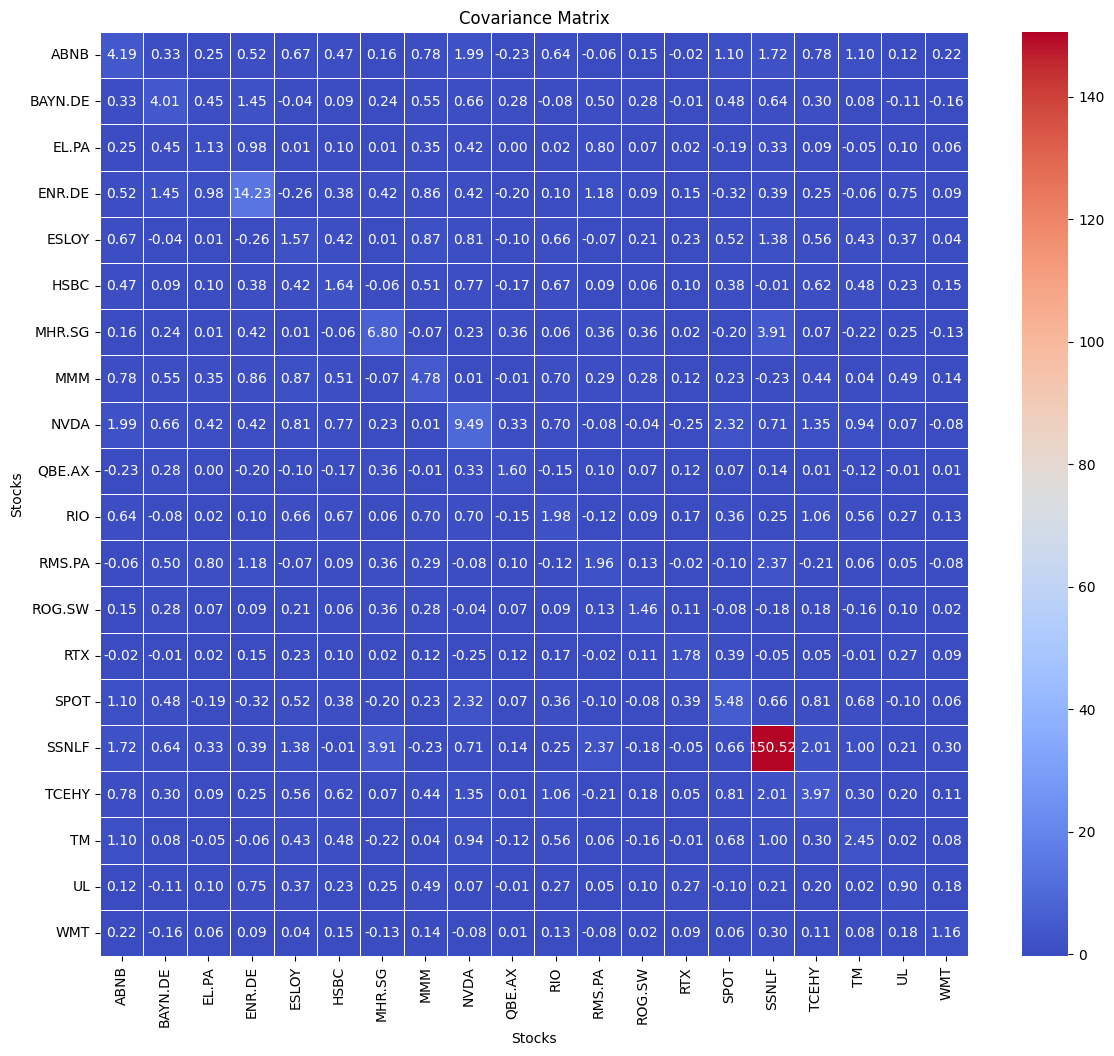

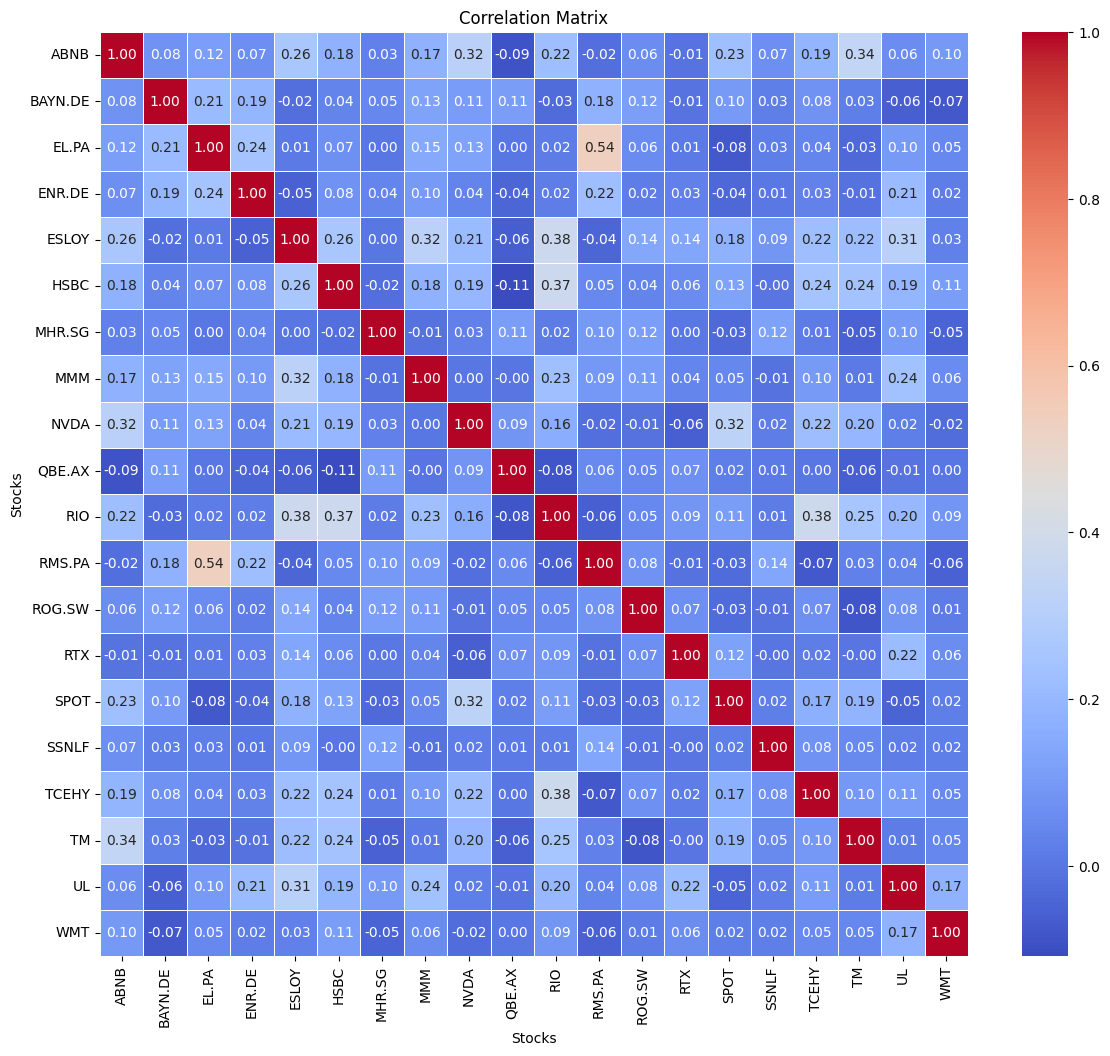

In [22]:
def plot_heatmap(matrix: pd.DataFrame, title: str) -> None:
    """
    This function plots a heatmap of the given matrix.

    Args:
        matrix (pd.DataFrame): The matrix to be plotted.
        title (str): The title of the plot.
    """
    # Create a heatmap
    plt.figure(figsize=(14, 12))  
    # Create a heatmap plot
    sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    
    # Set the title of the plot
    plt.title(title)
    plt.xlabel('Stocks')
    plt.ylabel('Stocks')
    
    # Display the plot
    plt.show()

# Plot the covariance matrix
plot_heatmap(cov_matrix, "Covariance Matrix")
# Plot the correlation matrix
plot_heatmap(corr_matrix, "Correlation Matrix")